In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from pyfolio.timeseries import perf_stats
%matplotlib inline

In [2]:
allocs = pd.Series([.05, .3, .35, .3, 1], index=['CL', 'ES', 'GC', 'NQ', 'total'])
cash = 100000

In [3]:
df = pd.read_csv('/home/tomek/ib_tools/backtests/backtest_2020-03-04_21-37_20190101_20191231.csv')
del df['sys_time']
del df['exec_ids']
try:
    del df['perm_id']
    del df['com_reports']
except:
    pass
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df['cash'] = df.realizedPNL.cumsum() + cash
df['contract'] = df['contract'].apply(lambda x: x[:-2])
df

,contract,action,amount,price,order_id,reason,commission,realizedPNL,comm_reports,cash
time,,,,,,,,,,
2019-01-02 01:56:00,NQ,BUY,3,6382.75,1,ENTRY,6.30,0.0,"[CommissionReport(execId=1, commission=6.30000...",100000.00
2019-01-02 02:10:00,ES,BUY,3,2518.75,3,ENTRY,6.30,0.0,"[CommissionReport(execId=2, commission=6.30000...",100000.00
2019-01-02 02:55:00,NQ,SELL,3,6354.75,2,STOP-LOSS,6.30,-1692.6,"[CommissionReport(execId=3, commission=6.30000...",98307.40
2019-01-02 03:37:00,ES,SELL,3,2488.50,4,STOP-LOSS,6.30,-4550.1,"[CommissionReport(execId=4, commission=6.30000...",93757.30
2019-01-02 06:19:00,GC,BUY,4,1287.10,5,ENTRY,9.68,0.0,"[CommissionReport(execId=5, commission=9.68, c...",93757.30
...,...,...,...,...,...,...,...,...,...,...
2019-12-30 15:51:00,NQ,BUY,2,8717.00,4461,STOP-LOSS,4.20,-48.4,"[CommissionReport(execId=4458, commission=4.2,...",148958.12
2019-12-30 15:53:00,NQ,SELL,2,8715.00,4462,ENTRY,4.20,0.0,"[CommissionReport(execId=4459, commission=4.2,...",148958.12
2019-12-30 16:08:00,NQ,BUY,2,8722.50,4463,STOP-LOSS,4.20,-308.4,"[CommissionReport(execId=4460, commission=4.2,...",148649.72


In [23]:
df[df['contract']=='CL'].sort_values('realizedPNL').head(50)

,contract,action,amount,price,order_id,reason,commission,realizedPNL,comm_reports,cash
time,,,,,,,,,,
2019-09-18 08:18:00,CL,BUY,1,59.07,3317,STOP-LOSS,2.37,-444.74,"[CommissionReport(execId=3316, commission=2.37...",144006.02
2019-09-17 19:48:00,CL,BUY,1,59.07,3313,STOP-LOSS,2.37,-444.74,"[CommissionReport(execId=3312, commission=2.37...",145249.16
2019-09-18 15:47:00,CL,BUY,1,58.35,3321,STOP-LOSS,2.37,-404.74,"[CommissionReport(execId=3320, commission=2.37...",143886.54
2019-09-16 00:04:00,CL,SELL,1,62.38,3291,STOP-LOSS,2.37,-394.74,"[CommissionReport(execId=3290, commission=2.37...",145373.86
2019-09-18 19:37:00,CL,BUY,1,58.01,3327,STOP-LOSS,2.37,-374.74,"[CommissionReport(execId=3326, commission=2.37...",143092.76
2019-01-04 13:38:00,CL,SELL,1,47.96,48,STOP-LOSS,2.37,-344.74,"[CommissionReport(execId=48, commission=2.37, ...",91342.04
2019-09-23 12:02:00,CL,BUY,1,57.79,3385,STOP-LOSS,2.37,-344.74,"[CommissionReport(execId=3384, commission=2.37...",135264.02
2019-01-07 16:40:00,CL,SELL,1,49.15,70,STOP-LOSS,2.37,-334.74,"[CommissionReport(execId=69, commission=2.37, ...",97732.20
2019-09-19 21:56:00,CL,BUY,1,58.45,3355,STOP-LOSS,2.37,-324.74,"[CommissionReport(execId=3354, commission=2.37...",139381.88


In [4]:
df.groupby('contract').realizedPNL.sum()

contract
CL   -11709.56
ES    32292.20
GC     2778.48
NQ    25510.20
Name: realizedPNL, dtype: float64

In [5]:
df.realizedPNL.sum()

48871.31999999999

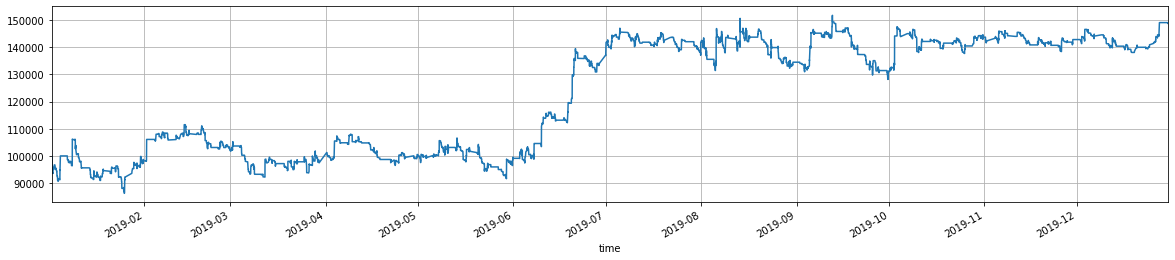

In [6]:
df.cash.plot(figsize=(20,4), grid=True);

In [7]:
by_contract = pd.pivot_table(df, values='realizedPNL', index=df.index, columns=['contract'])
by_contract['total'] = by_contract.sum(axis=1)

In [8]:
# number of trades
trades = df.groupby('contract').action.count()
trades

contract
CL    1388
ES     256
GC    1492
NQ    1326
Name: action, dtype: int64

In [9]:
# commission paid
df.groupby('contract').commission.sum()

contract
CL     3289.56
ES     1507.80
GC    11751.52
NQ     6589.80
Name: commission, dtype: float64

In [10]:
df.commission.sum()

23138.68

In [11]:
# per trade stats
exits = df[df.realizedPNL!=0]
dfs = {}
for contract in exits.contract.unique():
    dfs[contract] = exits[exits.contract == contract]
dfs['total'] = exits
results = pd.DataFrame(columns=['success_rate', 'average_PNL', 'average_gain', 'average_loss','win_ratio', 'EV',
                               'number_of_positions'])
for c, d in dfs.items():
    row = pd.Series()
    row['success_rate'] = round((d[d.realizedPNL > 0]).realizedPNL.count() / d.realizedPNL.count(), 2)
    row['average_PNL'] = round(d.realizedPNL.mean(), 2)
    row['average_gain'] = round((d[d.realizedPNL > 0]).realizedPNL.mean(), 2)
    row['average_loss'] = round((d[d.realizedPNL < 0]).realizedPNL.mean(), 2)
    row['win_ratio'] = round(abs(row['average_gain'] / row['average_loss']), 2)
    row['EV'] = round((row['average_gain'] * row['success_rate']) + (
        row['average_loss'] * (1 - row['success_rate'])), 2)
    row['number_of_positions'] = d.realizedPNL.count()
    results.loc[c] = row
results

,success_rate,average_PNL,average_gain,average_loss,win_ratio,EV,number_of_positions
NQ,0.41,38.48,896.65,-551.11,1.63,42.47,663.0
ES,0.41,252.28,2543.85,-1367.09,1.86,236.40,128.0
GC,0.39,3.72,795.83,-497.19,1.60,7.09,746.0
CL,0.36,-16.87,255.58,-168.37,1.52,-15.75,694.0
total,0.39,21.91,779.42,-453.27,1.72,27.48,2231.0


In [12]:
daily = by_contract.resample('B').sum()
daily = daily.cumsum() +  (allocs * cash)
#daily[['CL', 'ES', 'GC', 'NQ']].plot(figsize=(20,8), grid=True);

In [13]:
# instrument correlations
log_returns = np.log(daily.pct_change()[1:] + 1)
log_returns.corr()

contract,CL,ES,GC,NQ,total
contract,,,,,
CL,1.000000,0.017061,0.057356,-0.000662,0.114946
ES,0.017061,1.000000,-0.018688,0.101118,0.667354
GC,0.057356,-0.018688,1.000000,0.065857,0.452107
NQ,-0.000662,0.101118,0.065857,1.000000,0.636051
total,0.114946,0.667354,0.452107,0.636051,1.000000


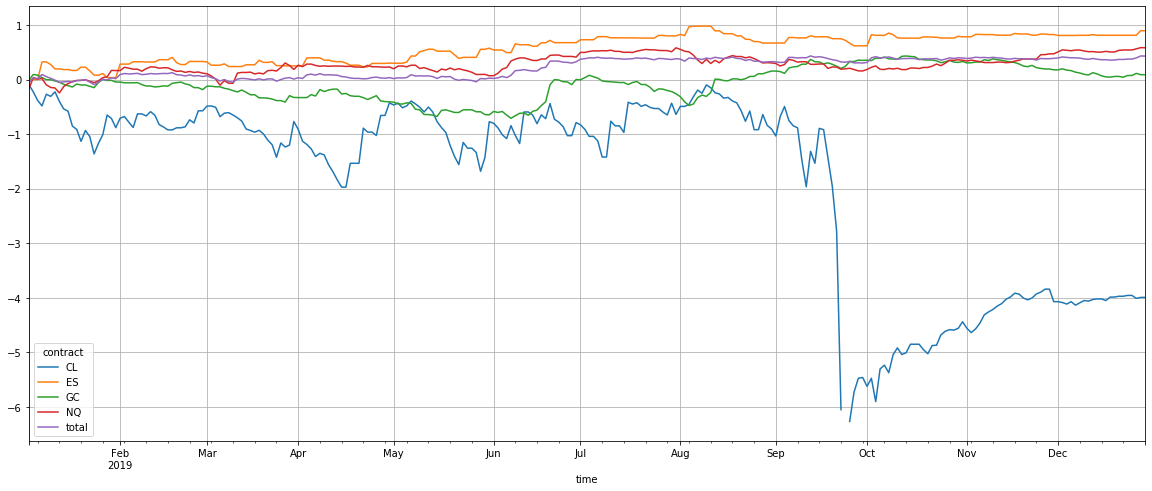

In [14]:
log_returns.cumsum().plot(figsize=(20,8), grid=True);

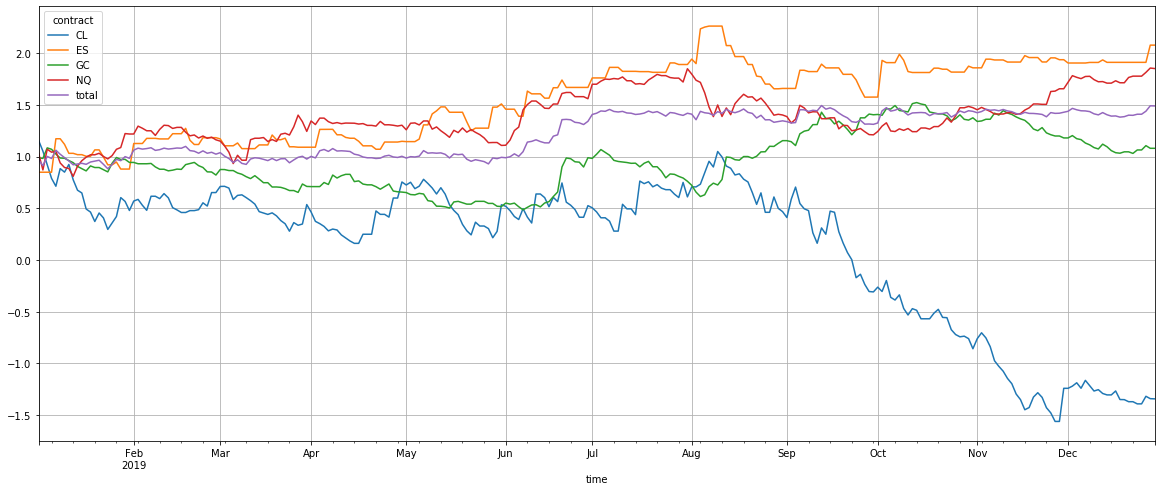

In [15]:
returns = daily.pct_change()
returns.iloc[0] = (daily.iloc[0] / (allocs * cash))-1
returns_index = (returns + 1).cumprod()
returns_index.plot(figsize=(20,8), grid=True);

In [16]:
stats = pd.DataFrame()
for col in returns.columns:
    stats[col] = perf_stats(returns[col])
stats

,CL,ES,GC,NQ,total
Annual return,NaN,1.035806,0.077159,0.819820,0.472789
Cumulative returns,-2.341912,1.076407,0.079385,0.850340,0.488713
Annual volatility,63.236448,0.763512,0.755353,0.653770,0.402710
Sharpe ratio,-0.927112,1.277872,0.446309,1.233601,1.157930
Calmar ratio,NaN,3.408732,0.139661,2.371724,2.799182
Stability,NaN,0.801618,0.324840,0.462230,0.755676
Max drawdown,-2.349321,-0.303868,-0.552474,-0.345664,-0.168902
Omega ratio,0.248377,1.471046,1.095108,1.277782,1.235665
Sortino ratio,-0.928425,2.856090,0.891706,2.118542,2.144129
Skew,-15.919971,3.442307,2.898432,1.140243,1.415113


In [17]:
# monthly returns in percent
monthly_log_returns = log_returns.resample('M').sum()
monthly_returns = np.exp(monthly_log_returns)-1
round(monthly_returns, 4) * 100

contract,CL,ES,GC,NQ,total
time,,,,,
2019-01-31,-58.62,3.58,-4.52,17.83,1.54
2019-02-28,36.18,34.52,-12.93,-4.60,4.09
2019-03-31,-17.79,-7.79,-13.40,7.01,-4.64
2019-04-30,40.71,5.23,-7.69,4.79,2.74
2019-05-31,-29.20,31.49,-21.26,-14.99,-1.00
2019-06-30,-1.58,10.58,91.24,40.76,35.06
2019-07-31,16.13,13.28,-23.00,18.61,5.83
2019-08-31,-23.39,-12.24,51.58,-24.19,-5.17
2019-09-30,-98.95,-5.04,21.68,-13.69,-2.52


In [18]:
# total returns by contract in percent
round(np.exp(monthly_log_returns.sum())-1, 2)* 100

contract
CL       -98.0
ES       145.0
GC         9.0
NQ        79.0
total     54.0
dtype: float64

In [19]:
df.sort_values('realizedPNL', ascending=False)[['contract', 'action', 'price', 'realizedPNL']]

,contract,action,price,realizedPNL
time,,,,
2019-10-02 20:46:00,ES,BUY,2891.75,10637.4
2019-08-05 21:20:00,ES,BUY,2841.75,10074.9
2019-01-08 16:51:00,ES,SELL,2551.25,9699.9
2019-06-10 03:00:00,ES,SELL,2881.00,7524.9
2019-02-01 20:18:00,ES,SELL,2698.75,7412.4
...,...,...,...,...
2019-05-21 02:00:00,ES,BUY,2851.50,-2787.6
2019-10-10 02:00:00,ES,BUY,2906.50,-3275.1
2019-08-13 17:17:00,ES,SELL,2921.50,-3462.6
